<a href="https://colab.research.google.com/github/Elman295/Cross-Domain-Gradient-Discrepancy-Minimization-for-Unsupervised-Domain-Adaptation/blob/main/Cross_Domain_Gradient_Discrepancy_Minimization_for_Unsupervised_Domain_Adaptation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt


import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torch import nn
from torch.autograd import grad

In [2]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")


#`Data`

In [3]:
tfms = transforms.Compose([
    transforms.Resize(size = (28,28)),
    transforms.ToTensor(),
    transforms.Normalize(mean = 0.5, std = 0.5)
])

In [4]:
MNIST_train = datasets.MNIST(
    root = "data",
    train = True,
    download = True,
    transform = tfms
)

MNIST_test = datasets.MNIST(
    root = "data",
    train = False,
    download = True,
    transform = tfms
)

USPS_train = datasets.USPS(
    root = "data",
    train = True,
    download = True,
    transform = tfms
)

USPS_test = datasets.USPS(
    root = "data",
    train = False,
    download = True,
    transform = tfms
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 17633735.76it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 477124.44it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4406839.63it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3857163.14it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 6579383/6579383 [00:01<00:00, 5857309.02it/s] 


100%|██████████| 1831726/1831726 [00:00<00:00, 2111214.65it/s]


In [5]:

source_train_dl = DataLoader(dataset = MNIST_train, batch_size = 128, shuffle = True)
source_test_dl = DataLoader(dataset = MNIST_test, batch_size = 128, shuffle = False)

target_train_dl = DataLoader(dataset=USPS_train, batch_size = 128, shuffle = True)
target_test_dl = DataLoader(dataset = USPS_test, batch_size=128, shuffle = False)

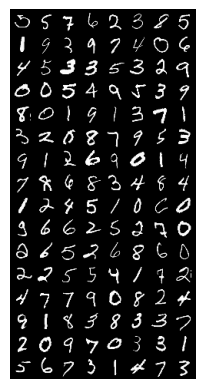

In [6]:
image, label = next(iter(source_train_dl))
outs = torchvision.utils.make_grid(image)

plt.imshow(outs.permute(1,2,0))
plt.axis("off")
plt.show()

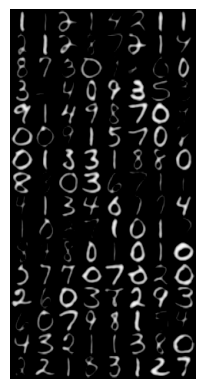

In [7]:
image, label = next(iter(target_train_dl))
outs = torchvision.utils.make_grid(image)

plt.imshow(outs.permute(1,2,0))
plt.axis("off")
plt.show()


#`Function`

In [8]:
def discrepancy_loss(f1,f2):
  return torch.mean(torch.abs(F.softmax(f1) - F.softmax(f2)))

In [9]:
def loss_GD(gs, gt):

  res = 1 - ((gs.T @ gt)/(torch.norm(gs, p=2) * torch.norm(gt, p = 2)))
  return res

In [10]:
def mean_grad(g1,g2):
  return torch.mean(g1,g2)

In [11]:
def ck(F1,F2, G, xt):

  res_1 = torch.sum(F.softmax(F1(G(xt)))) * G(xt)
  res_2 = torch.sum(F.softmax(F2(G(xt)))) * G(xt)

  res_3 = torch.sum(F.softmax(F1(G(xt))))
  res_4 = torch.sum(F.softmax(F2(G(xt))))

  res = (res_1 + res_2) / (res_3 + res_4)

  return res



In [12]:
def pseudo_label(G,xt,ck, k =10):

  print(F.pairwise_distance(G(xt), ck))

  return torch.argmin(F.pairwise_distance(G(xt), ck))

In [13]:
x = torch.tensor([1,2,3], dtype = torch.float32)
torch.norm(x, p = 2)

tensor(3.7417)

#`Models`

In [14]:
class Generator(nn.Module):
    """LeNet encoder model for ADDA."""

    def __init__(self):
      super(Generator, self).__init__()
      self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1)
      self.bn1 = nn.BatchNorm2d(32)
      self.conv2 = nn.Conv2d(32, 48, kernel_size=5, stride=1)
      self.bn2 = nn.BatchNorm2d(48)

    def forward(self, x):
        x = torch.mean(x,1).view(x.size()[0],1,x.size()[2],x.size()[3])
        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), stride=2, kernel_size=2, dilation=(1, 1))
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), stride=2, kernel_size=2, dilation=(1, 1))
        #print(x.size())
        x = x.view(x.size(0), 48*4*4)
        return x


In [15]:
class Classifier(nn.Module):
    def __init__(self, prob=0.5):
          super(Classifier, self).__init__()
          self.fc1 = nn.Linear(48*4*4, 100)
          self.bn1_fc = nn.BatchNorm1d(100)
          self.fc2 = nn.Linear(100, 100)
          self.bn2_fc = nn.BatchNorm1d(100)
          self.fc3 = nn.Linear(100, 10)
          self.bn_fc3 = nn.BatchNorm1d(10)
          self.prob = prob

    def set_lambda(self, lambd):
        self.lambd = lambd
    def forward(self, x):
        x = F.dropout(x, training=self.training, p=self.prob)
        x = F.relu(self.bn1_fc(self.fc1(x)))
        x = F.dropout(x, training=self.training, p=self.prob)
        x = F.relu(self.bn2_fc(self.fc2(x)))
        x = F.dropout(x, training=self.training, p=self.prob)
        x = self.fc3(x)
        return x

In [16]:

G = Generator().to(device)
F1 = Classifier().to(device)
F2 = Classifier().to(device)

In [17]:
xt = torch.rand(size = (16,1,28,28))
z = G(xt)
print(z.shape)
y = ck(F1, F2, G, xt)

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [ ]:
y.shape

In [18]:
xx = pseudo_label(G,xt,y)

NameError: name 'y' is not defined

In [ ]:
xx.shape

In [19]:
xx

NameError: name 'xx' is not defined

#`Optimizers`

In [20]:

G_opt = torch.optim.Adam(params = G.parameters(), lr =  1e-4)
F1_opt = torch.optim.Adam(params = F1.parameters(), lr =  1e-4)
F2_opt = torch.optim.Adam(params = F2.parameters(), lr =  1e-4)

#`Train`

In [22]:
def train(data_s, data_t, G, F1, F2, loss_ce, discrepancy_loss, G_opt, F1_opt, F2_opt, N):
  G.train()
  F1.train()
  F2.train()

  size = len(data_s.dataset)

  for b, ((x_s,y_s),(x_t,_)) in enumerate(zip(data_s, data_t)):

    x_s, y_s, x_t = x_s.to(device), y_s.to(device), x_t.to(device)

    # stepA

    G_opt.zero_grad()
    F1_opt.zero_grad()
    F2_opt.zero_grad()

    fs_A = G(x_s)
    y1_s_A = F1(fs_A)
    y2_s_A = F2(fs_A)

    loss_1_A = loss_ce(y1_s_A, y_s)
    loss_2_A = loss_ce(y2_s_A, y_s)
    lossA_1 = loss_1_A + loss_2_A

    fps_A = G(x_t)
    y1_ps_A = F1(fps_A)
    y2_ps_A = F2(fps_A)
    y_pseudo = y1_ps_A + y2_ps_A
    loss_ps_1_A = loss_ce(y1_ps_A, y_pseudo.argmax(1))
    loss_ps_2_A = loss_ce(y2_ps_A, y_pseudo.argmax(1))

    lossA_2 = loss_ps_1_A + loss_ps_2_A

    lossA = lossA_1 + (0.1 * lossA_2)


    lossA.backward()

    G_opt.step()
    F1_opt.step()
    F2_opt.step()


    # stepB


    G_opt.zero_grad()
    F1_opt.zero_grad()
    F2_opt.zero_grad()

    fs_B = G(x_s)
    y1_s_B = F1(fs_B)
    y2_s_B = F2(fs_B)
    loss_1_B = loss_ce(y1_s_B, y_s)
    loss_2_B = loss_ce(y2_s_B, y_s)
    loss_ce_B = loss_1_B + loss_2_B

    ft_B = G(x_t)
    y1_t_B = F1(ft_B)
    y2_t_B = F2(ft_B)
    loss_adv = discrepancy_loss(y1_t_B, y2_t_B)

    lossB = loss_ce_B - loss_adv

    lossB.backward()
    F1_opt.step()
    F2_opt.step()

    G_opt.zero_grad()
    F1_opt.zero_grad()
    F2_opt.zero_grad()

    # stepC

    for n in range(N):
      ft_C = G(x_t)
      y1_t_C = F1(ft_C)
      y2_t_C = F2(ft_C)
      # print(F1(G(x_s)).grad)


      rs_C = G(x_s)
      y1_rs_C = F1(fps_A)
      y2_rs_C = F2(fps_A)
      y_pseudo = y1_t_C + y2_t_C


      lossC = discrepancy_loss(y1_t_C, y2_t_C)
      lossC.backward()

      G_opt.step()

      G_opt.zero_grad()
      F1_opt.zero_grad()
      F2_opt.zero_grad()


    if b % 100 == 0:
      print(f"lossA:{lossA.item()} lossB:{lossB.item()} lossC:{lossC.item()}")

#`test`

In [23]:
def test(data, G, F1, F2, loss_ce):

  G.eval()
  F1.eval()
  F2.eval()

  size = len(data.dataset)
  num_batch = len(data)

  test_acc_1, test_loss_1 = 0,0
  test_acc_2, test_loss_2 = 0,0

  with torch.no_grad():
    for x,y in data:
      x,y = x.to(device), y.to(device)

      f = G(x)
      y1 = F1(f)
      y2 = F2(f)
      test_loss_1 += loss_ce(y1,y).item()
      test_loss_2 += loss_ce(y2,y).item()
      test_acc_1 += (y1.argmax(1) == y).type(torch.float).sum().item()
      test_acc_2 += (y2.argmax(1) == y).type(torch.float).sum().item()


    test_loss_1 /= num_batch
    test_loss_2 /= num_batch

    test_acc_1 /= size
    test_acc_2 /= size

    print(f"F1 loss : {test_loss_1} F1 accuracy: {test_acc_1 * 100}")
    print(f"F2 loss : {test_loss_2} F2 accuracy: {test_acc_2 * 100}")

#`Training`

In [24]:
loss_ce = nn.CrossEntropyLoss()

In [25]:

for epoch in range(70):
  print(f"epoch : {epoch+1}=-=-=-=-=-=-")
  train(source_train_dl, target_train_dl, G, F1, F2, loss_ce, discrepancy_loss, G_opt, F1_opt, F2_opt, N = 1)
  print(f"target:")
  test(target_train_dl, G, F1, F2, loss_ce)
  print("source:")
  test(source_test_dl, G, F1, F2, loss_ce)

epoch : 1=-=-=-=-=-=-


<ipython-input-8-a642ba8e7794>:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return torch.mean(torch.abs(F.softmax(f1) - F.softmax(f2)))


lossA:5.09080171585083 lossB:4.939769744873047 lossC:0.05449127033352852
target:
F1 loss : 1.9768358552665042 F1 accuracy: 35.70154985598683
F2 loss : 1.934242100046392 F2 accuracy: 40.03566040323687
source:
F1 loss : 1.6898841073241415 F1 accuracy: 66.17
F2 loss : 1.6588039081307906 F2 accuracy: 71.39999999999999
epoch : 2=-=-=-=-=-=-
lossA:4.149146556854248 lossB:3.7189111709594727 lossC:0.05514798313379288
target:
F1 loss : 1.7384581544943023 F1 accuracy: 44.0405979975312
F2 loss : 1.7165994727820681 F2 accuracy: 44.342339871073925
source:
F1 loss : 1.215005198611489 F1 accuracy: 76.82
F2 loss : 1.1887644876407673 F2 accuracy: 84.2
epoch : 3=-=-=-=-=-=-
lossA:3.355452060699463 lossB:2.9480605125427246 lossC:0.059097159653902054
target:
F1 loss : 1.557384683374773 F1 accuracy: 50.130297627211625
F2 loss : 1.5470202073716282 F2 accuracy: 49.41708956247428
source:
F1 loss : 0.8919300059728985 F1 accuracy: 84.04
F2 loss : 0.8414222326459764 F2 accuracy: 89.21
epoch : 4=-=-=-=-=-=-
lossA